# Feature detection com SIFT em OpenCV


Exemplos extraídos do tutorial  [Scipy4CV ministrado por Thiago Santos no Simpósio Brasileiro de Computação Gráfica e Processamento de Imagens](https://github.com/thsant/scipy4cv)

Referências para este assunto:

[Computer Vision - Algorithms and Applications. Richard Szeliski](http://szeliski.org/Book/)
- Capítulo 3 - Image processing
- Capítulo 4 - Feature Detectors and Matching
    
[Capítulo 2 - Local Image Descriptors do Livro de Python/OpenCV de Jan Solem](http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf)

SIFT significa Scale-Invariant Feature Transforms, e é uma técnica que permite encontrar pontos únicos em uma imagem e identificá-los novamente em outras imagens,




In [1]:

import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import pi
import matplotlib.cm as cm

# Enxergando as features

In [2]:
box = cv2.imread('box.png',0)

A função `cv2.xfeatures2d.SIFT_create()` identifica as *features* únicas de uma imagem

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
kpts = sift.detect(box)
x = [k.pt[0] for k in kpts]
y = [k.pt[1] for k in kpts]
# s will correspond to the neighborhood area
s = [(k.size/2)**2 * pi for k in kpts]


Vamos visualizar as imagens com as features

Text(0.5,1,'SIFT')

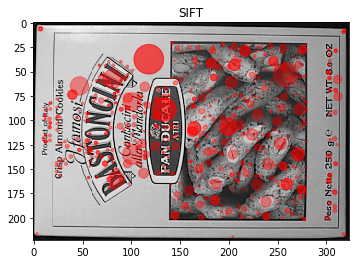

In [4]:
plt.scatter(x, y, s, c='r', alpha=0.4)
plt.imshow(box, cmap=cm.gray)
plt.title('SIFT')

In [5]:
# Esta função não é importante, apenas desenha as features na imagem
def draw_points(matches, img_original, img_cena, kp1, kp2): 
    for mat in matches:
            # Get the matching keypoints for each of the images
            img1_idx = mat[0].queryIdx
            img2_idx = mat[0].trainIdx

            # x - columns
            # y - rows
            (x1,y1) = kp1[img1_idx].pt
            (x2,y2) = kp2[img2_idx].pt

            # Draw a small circle at both co-ordinates
            # radius 4
            # colour blue
            # thickness = 1
            cv2.circle(img_original, (int(x1),int(y1)), 4, (255, 0, 0), 1)
            #cv2.circle(img_cena, (int(x2),int(y2)), 4, (255, 0, 0), 1)

## O que implementar em seu código

O exemplo abaixo carrega duas imagens. A `img_original` é o objeto a ser encontrado, e a `img_cena` contém uma cena que contém o objeto

In [6]:
! open insperlogo.jpeg

In [7]:
# Número mínimo de pontos correspondentes
MIN_MATCH_COUNT = 10

img_original = cv2.imread('insperlogo.jpeg',0)      # Gabarito / Imagem a procurar
img_cena = cv2.imread('insperlogo.jpeg',0) # Imagem do cenario - puxe do video para fazer isto

# Versões RGB das imagens, para plot
original_rgb = cv2.cvtColor(img_original, cv2.COLOR_GRAY2RGB)
cena_rgb = cv2.cvtColor(img_cena, cv2.COLOR_GRAY2RGB)

# Imagem de saída
out = cena_rgb.copy()


# Cria o detector SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Encontra os pontos únicos (keypoints) nas duas imagems
kp1, des1 = sift.detectAndCompute(img_original ,None)
kp2, des2 = sift.detectAndCompute(img_cena,None)

# Configurações do algoritmo FLANN que compara keypoints e ver correspondências - não se preocupe com isso
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

# Configura o algoritmo de casamento de features que vê *como* o objeto que deve ser encontrado aparece na imagem
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Tenta fazer a melhor comparacao usando o algoritmo
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


if len(good)>MIN_MATCH_COUNT:
    # Separa os bons matches na origem e no destino
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)


    # Tenta achar uma trasformacao composta de rotacao, translacao e escala que situe uma imagem na outra
    # Esta transformação é chamada de homografia 
    # Para saber mais veja 
    # https://docs.opencv.org/3.4/d9/dab/tutorial_homography.html
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()


    
    h,w = img_original.shape
    # Um retângulo com as dimensões da imagem original
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    # Transforma os pontos do retângulo para onde estao na imagem destino usando a homografia encontrada
    dst = cv2.perspectiveTransform(pts,M)


    # Desenha um contorno em vermelho ao redor de onde o objeto foi encontrado
    img2b = cv2.polylines(out,[np.int32(dst)],True,(255,0,0),3, cv2.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

# Vocês não precisam disto: desenham os pontos
draw_points(matches, img_original, img_cena, kp1, kp2)









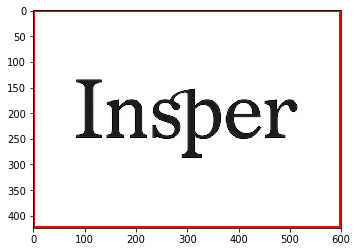

(<matplotlib.image.AxesImage at 0x1189e3048>, None)

In [8]:
plt.imshow(out), plt.show()

Vamos rever os feature points da imagem

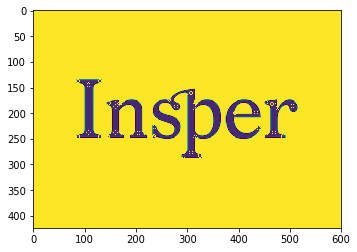

In [9]:
plt.imshow(img_original)
